In [ ]:
# ..... get within-species pseudobulk coexp net's coexp cons scores across stages ..... #

In [1]:
get_top_pairs_mat <- function (mat.rank, n){ 
  f = mat.rank>dim(mat.rank)[1]-n
  mat.pairs = mat.rank*0
  mat.pairs[f] = 1
  return(mat.pairs)
}    

auroc_analytic2 <-function (mat, np, nL) { 
  ranks = 1:nL
  mini = sum(ranks[1:np])
  maxi = sum(ranks[(nL-np+1):nL])    
  range = maxi - mini    
  auroc <- (mat - mini)/range
  return(auroc)
}

roc_bg_predict <- function (bg_predict_res, species1, species2, np, nL){
  rocs = matrix(0, ncol = 2, nrow = dim(bg_predict_res[[1]])[2])
  colnames(rocs) = c(species1,species2)
  #   rownames(rocs) = rownames(bg_predict_res[[1]])
  
  ranks = 1:nL
  mini = sum(ranks[1:np])
  maxi = sum(ranks[(nL-np+1):nL])    
  range = maxi - mini
  
  for(i in 1:2){
    temp = t(apply(bg_predict_res[[i]], 1, function(x) rank(x, ties.method = "average")))        
    rocs[,i] <- (diag(temp) - mini)/range       
  }
  return(rocs)
}

In [5]:
# donor vs TOF, DCM, HCM, HF_HLHS, Neo_HLHS
stage1 = 'Donor'
load(paste0('CHD_', stage1, '_coexp_net.Rdata'))
coexp_species1 = cor1

# check that both nets have same genes
# setdiff(rownames(coexp_species1), rownames(coexp_species2))

character(0)

In [18]:
stage2 = 'Neo_HLHS'
load(paste0('CHD_', stage2, '_coexp_net.Rdata'))
coexp_species2 = cor1

In [19]:
# calculate ranks and top 10s
rank_species1 = apply(coexp_species1, 1, rank, ties.method = 'average')
rank_species2 = apply(coexp_species2, 1, rank, ties.method = 'average')

mat1 = get_top_pairs_mat(t(rank_species1), 10)
mat2 = get_top_pairs_mat(t(rank_species2), 10)

gg_sp12 = mat1%*%rank_species2    # stage1 genes predict stage2 genes this well
gg_sp21 = mat2%*%rank_species1    # stage2 genes predict stage1 genes this well

res.mat1 = auroc_analytic2(gg_sp12, 10, dim(mat1)[2])
res.mat2 = auroc_analytic2(gg_sp21, 10, dim(mat2)[2])
res = vector("list", length = 2)
res[[1]] = res.mat1
res[[2]] = res.mat2


# function conservation and specificity scores #
fncons_aurocs = matrix(0, ncol = 2, nrow = dim(res[[1]])[2])
colnames(fncons_aurocs) = c(stage2, stage1)
fncons_aurocs[,1] = diag(res.mat1)
fncons_aurocs[,2] = diag(res.mat2)

spec_aurocs = roc_bg_predict(res, stage2, stage1, 1, dim(mat1)[1])

geneList = cbind(rownames(coexp_species1), rownames(coexp_species2))
colnames(geneList) = c(stage1, stage2)

roc_scores = data.frame(geneList, rowMeans(fncons_aurocs), rowMeans(spec_aurocs))
colnames(roc_scores) <- c('Donor', 'Disease', 'fc', 'sc')

# save
fileo = paste0('CHD_', stage1, '_', stage2, '_pseudobulk_coexp_cons.csv')
write.table(roc_scores, file = fileo, sep = ',', row.names = F, col.names = T, quote = F)

[1] 29266     4

Donor    Disease  fc        sc       
16942 TBX5     TBX5     0.7507152 0.9200666
16943 TBX5-AS1 TBX5-AS1 0.3724680 0.9076200

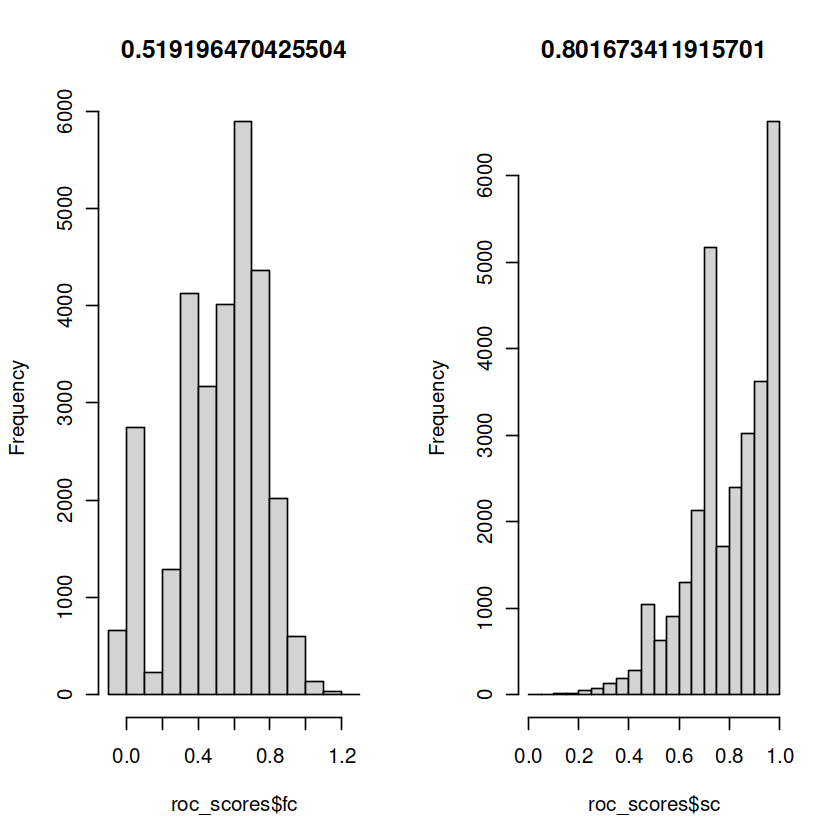

In [20]:
dim(roc_scores)
roc_scores[grep('TBX5', roc_scores[,1]),]

par(mfrow=c(1,2))
hist(roc_scores$fc, main = mean(roc_scores$fc, na.rm = T))
hist(roc_scores$sc, main = mean(roc_scores$sc, na.rm = T))